## **Bi-encoder**

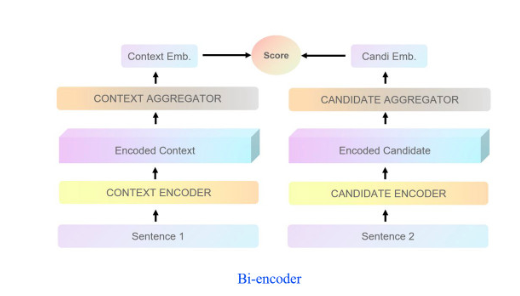

In [ ]:
import pandas as pd
import numpy as np


In [ ]:
faq = pd.read_excel('/content/drive/MyDrive/FAQ-CMR.xlsx')

Tout d'abord, nous installons sentence-transformers:

In [ ]:
device = 'cuda'
import torch, gc
import os
gc.collect()
torch.cuda.empty_cache()

In [ ]:
!pip install sentence-transformers -q
!pip install datasets -q

     |████████████████████████████████| 79 kB 3.9 MB/s 
     |████████████████████████████████| 4.2 MB 10.9 MB/s 
     |████████████████████████████████| 1.2 MB 72.0 MB/s 
     |████████████████████████████████| 86 kB 5.4 MB/s 
     |████████████████████████████████| 596 kB 58.1 MB/s 
     |████████████████████████████████| 6.6 MB 55.2 MB/s 
     |████████████████████████████████| 346 kB 5.2 MB/s 
     |████████████████████████████████| 212 kB 66.1 MB/s 
     |████████████████████████████████| 140 kB 72.1 MB/s 
     |████████████████████████████████| 86 kB 6.9 MB/s 
     |████████████████████████████████| 1.1 MB 68.6 MB/s 
     |████████████████████████████████| 127 kB 75.5 MB/s 
     |████████████████████████████████| 144 kB 57.7 MB/s 
     |████████████████████████████████| 271 kB 73.7 MB/s 
     |████████████████████████████████| 94 kB 4.0 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of 

Ensuite, nous téléchargeons le jeu de données :

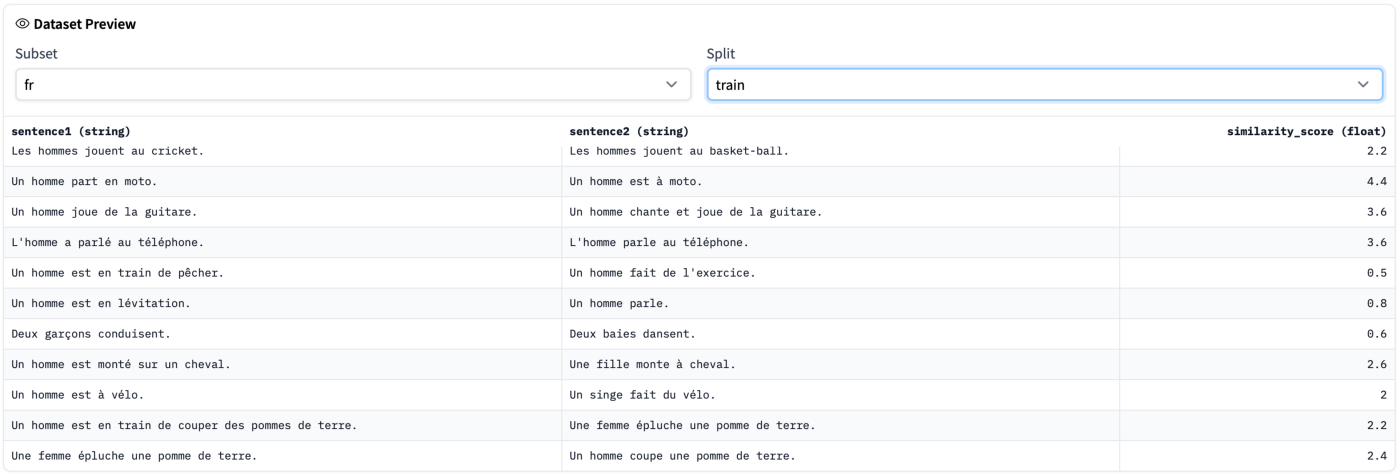

In [ ]:
from datasets import load_dataset
df_train = load_dataset("stsb_multi_mt", name="fr", split="train")
df_valid = load_dataset("stsb_multi_mt", name="fr", split="dev")
df_test = load_dataset("stsb_multi_mt", name="fr", split="test")

Generating train split:   0%|          | 0/5749 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1379 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/1500 [00:00<?, ? examples/s]

Dataset stsb_multi_mt downloaded and prepared to /root/.cache/huggingface/datasets/stsb_multi_mt/fr/1.0.0/a5d260e4b7aa82d1ab7379523a005a366d9b124c76a5a5cf0c4c5365458b0ba9. Subsequent calls will reuse this data.


Reusing dataset stsb_multi_mt (/root/.cache/huggingface/datasets/stsb_multi_mt/fr/1.0.0/a5d260e4b7aa82d1ab7379523a005a366d9b124c76a5a5cf0c4c5365458b0ba9)
Reusing dataset stsb_multi_mt (/root/.cache/huggingface/datasets/stsb_multi_mt/fr/1.0.0/a5d260e4b7aa82d1ab7379523a005a366d9b124c76a5a5cf0c4c5365458b0ba9)


Nous construisons un DataLoader prêt pour la formation en utilisant l'ensemble de données.

/// Dataloader a été utilisé pour paralléliser le chargement des données car cela augmente la vitesse et économise de la mémoire. 

In [ ]:
from sentence_transformers import SentenceTransformer,  models, util
from sentence_transformers.readers import InputExample
from torch.utils.data import DataLoader

def convert_dataset(dataset):
    dataset_samples=[]
    for df in dataset:
        score = float(df['similarity_score'])/5.0  # Normalize score to range 0 ... 1
        inp_example = InputExample(texts=[df['sentence1'], 
                                    df['sentence2']], label=score)
        dataset_samples.append(inp_example)
    return dataset_samples
    
train_samples = convert_dataset(df_train)
dev_samples = convert_dataset(df_valid)
test_samples = convert_dataset(df_test)

# Convert the dataset to a DataLoader ready for training
batch_size = 16
train_dataloader = DataLoader(train_samples, shuffle=True, batch_size=batch_size)

Ensuite, nous définissons la fonction de perte basée sur la fonction cosinus-similitude :

In [ ]:
# Define the loss function.
from typing import Iterable, Dict
from torch import nn, Tensor
import torch


class CosineSimilarityLoss(nn.Module):
    """
    CosineSimilarityLoss expects, that the InputExamples consists of two texts and a float label.
    It computes the vectors u = model(input_text[0]) and v = model(input_text[1]) and measures the cosine-similarity between the two.
    Minimizes the following loss: 
                   ||input_label - cos_score_transformation(cosine_sim(u,v))||_2.
    :param model: SentenceTranformer model
    :param loss_fct: loss function is used to compare the cosine_similartiy(u,v) with the input_label. 
                  MSE = ||input_label - cosine_sim(u,v)||_2
    :param cos_score_transformation: The cos_score_transformation function is applied on top of cosine_similarity
    """
    def __init__(self, model: SentenceTransformer, 
                 loss_fct = nn.MSELoss(), 
                 cos_score_transformation=nn.Identity()):
        super(CosineSimilarityLoss, self).__init__()
        self.model = model
        self.loss_fct = loss_fct
        self.cos_score_transformation = cos_score_transformation

    def forward(self, sentence_features: Iterable[Dict[str, Tensor]], labels: Tensor):
        embeddings = [self.model(sentence_feature)['sentence_embedding'] for sentence_feature in sentence_features]
        output = self.cos_score_transformation(torch.cosine_similarity(embeddings[0], embeddings[1]))
        return self.loss_fct(output, labels.view(-1))

//// L'architecture du modèle est définie sur la base du CamemBERT-large pré-formé avec sa dimension de sortie étant de 1024, et nous choisissons de définir le paramètre max_seq_length des phrases d'entrée sur 128

In [ ]:
from sentence_transformers import SentenceTransformer,  models, util
from datetime import datetime
# Use Huggingface/transformers CamemBERT model for mapping tokens to embeddings
model_name =  "camembert/camembert-large"
model_save_path = 'output/training_stsbenchmark_'+model_name.replace("/", "-")+'-'+datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
max_seq_length = 128
word_embedding_model = models.Transformer(model_name, max_seq_length=max_seq_length)
# Apply mean pooling to get one fixed sized sentence vector
"""Performs pooling (max or mean) on the token embeddings.
  It generates from a variable sized sentence a fixed sized sentence embedding, 
  allows to use the CLS token if it is returned by the underlying word embedding model.
  We can concatenate multiple poolings together.
  - word_embedding_dimension: Dimensions for the word embeddings
  - pooling_mode_cls_token: Use the first token (CLS token) as text representations
  - pooling_mode_max_tokens: Use max in each dimension over all tokens.
  - pooling_mode_mean_tokens: Perform mean-pooling
  """
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension(),
                               pooling_mode_cls_token=False,
                               pooling_mode_max_tokens=False,
                               pooling_mode_mean_tokens=True)
model = SentenceTransformer(modules=[word_embedding_model, pooling_model])

Downloading:   0%|          | 0.00/456 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.26G [00:00<?, ?B/s]

Some weights of the model checkpoint at camembert/camembert-large were not used when initializing CamembertModel: ['lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing CamembertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/790k [00:00<?, ?B/s]

//// Training loss and evaluation pendant l'entraînement sont alors définies :

In [ ]:
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator
import math
import logging
num_epochs = 10
train_loss = CosineSimilarityLoss(model=model)
warmup_steps = math.ceil(len(train_dataloader) * num_epochs  * 0.1) #10% of train data for warm-up
logging.info("Warmup-steps: {}".format(warmup_steps))

logging.info("Read STSbenchmark dev dataset")
evaluator = EmbeddingSimilarityEvaluator.from_input_examples(dev_samples, name='sts-dev', write_csv=True) #Evaluate a model based on the similarity of the embeddings by calculating the Spearman 
                                                          #and Pearson rank correlation in comparison to the gold standard labels. The metrics are the cosine similarity as well as 
                                                      #euclidean and Manhattan distance The returned score is the Spearman correlation with a specified metric.


Train the model

In [ ]:
# Train the model
model.fit(train_objectives=[(train_dataloader, train_loss)],
          evaluator=evaluator,
          epochs=num_epochs,
          evaluation_steps=1000,
          optimizer_params={'lr': 1e-5, 
                            'eps': 1e-6, 
                            'correct_bias': False},
          save_best_model = True,
          warmup_steps=warmup_steps,
          output_path=model_save_path)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/360 [00:00<?, ?it/s]

Iteration:   0%|          | 0/360 [00:00<?, ?it/s]

Iteration:   0%|          | 0/360 [00:00<?, ?it/s]

Iteration:   0%|          | 0/360 [00:00<?, ?it/s]

Iteration:   0%|          | 0/360 [00:00<?, ?it/s]

Iteration:   0%|          | 0/360 [00:00<?, ?it/s]

Iteration:   0%|          | 0/360 [00:00<?, ?it/s]

Iteration:   0%|          | 0/360 [00:00<?, ?it/s]

Iteration:   0%|          | 0/360 [00:00<?, ?it/s]

Iteration:   0%|          | 0/360 [00:00<?, ?it/s]

Nous évaluons ensuite l'ensemble de test en utilisant le modèle le mieux enregistré :

In [ ]:
bi_encoder_camembert = SentenceTransformer(model_save_path)

In [ ]:
import pandas as pd
valid_metrics = pd.read_csv("/content/output/training_stsbenchmark_camembert-camembert-large-2022-05-30_20-42-32/eval/similarity_evaluation_sts-dev_results.csv")
valid_metrics

,epoch,steps,cosine_pearson,cosine_spearman,euclidean_pearson,euclidean_spearman,manhattan_pearson,manhattan_spearman,dot_pearson,dot_spearman
0,0,-1,0.858854,0.857466,0.844091,0.845680,0.843196,0.844803,0.808776,0.806355
1,1,-1,0.863625,0.863002,0.853240,0.852550,0.852631,0.851929,0.828750,0.823468
2,2,-1,0.872648,0.872030,0.856924,0.860957,0.856505,0.860063,0.843531,0.843570
3,3,-1,0.873031,0.872208,0.860006,0.863148,0.859662,0.862762,0.846975,0.844982
4,4,-1,0.873892,0.872695,0.862140,0.865631,0.861628,0.864972,0.854309,0.851522
5,5,-1,0.874547,0.873565,0.864443,0.868378,0.864280,0.868077,0.850852,0.847718
6,6,-1,0.874174,0.873279,0.863170,0.866613,0.862751,0.866054,0.851601,0.848853
7,7,-1,0.874256,0.873346,0.862941,0.866207,0.862692,0.865903,0.849850,0.847121
8,8,-1,0.874209,0.873389,0.863535,0.866808,0.863204,0.866297,0.850750,0.847757
9,9,-1,0.874809,0.873824,0.863654,0.867127,0.863380,0.866748,0.850419,0.847657


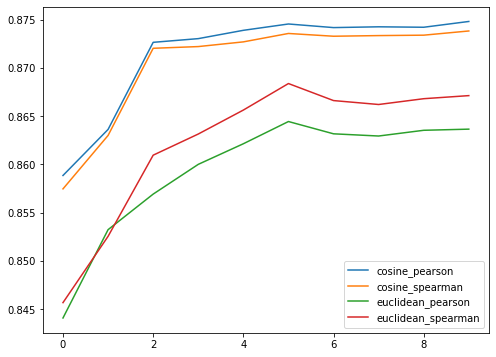

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.plot(valid_metrics['epoch'], valid_metrics["cosine_pearson"], label="cosine_pearson")
plt.plot(valid_metrics['epoch'], valid_metrics["cosine_spearman"], label ='cosine_spearman')

plt.plot(valid_metrics['epoch'], valid_metrics["euclidean_pearson"], label="euclidean_pearson")
plt.plot(valid_metrics['epoch'], valid_metrics["euclidean_spearman"], label ='euclidean_spearman')

plt.legend()
plt.show() 

In [ ]:
# Performance on train data
train_evaluator = EmbeddingSimilarityEvaluator.from_input_examples(train_samples, name='sts-train')
train_evaluator(model, output_path=model_save_path)

0.9870076795759609

In [ ]:
# All metrics for train data
train_metrics = pd.read_csv("/content/output/training_stsbenchmark_camembert-camembert-large-2022-05-30_20-42-32/similarity_evaluation_sts-train_results.csv")
train_metrics

,epoch,steps,cosine_pearson,cosine_spearman,euclidean_pearson,euclidean_spearman,manhattan_pearson,manhattan_spearman,dot_pearson,dot_spearman
0,-1,-1,0.98792,0.987008,0.974671,0.981639,0.974385,0.981331,0.966626,0.959329


In [ ]:
# Performance on test data
test_evaluator = EmbeddingSimilarityEvaluator.from_input_examples(test_samples, name='sts-test')
test_evaluator(model, output_path=model_save_path)

0.8557757027799966

In [ ]:
# All Metrics for test data
test_metrics = pd.read_csv("/content/output/training_stsbenchmark_camembert-camembert-large-2022-05-30_20-42-32/similarity_evaluation_sts-test_results.csv")
test_metrics

,epoch,steps,cosine_pearson,cosine_spearman,euclidean_pearson,euclidean_spearman,manhattan_pearson,manhattan_spearman,dot_pearson,dot_spearman
0,-1,-1,0.85644,0.855776,0.846576,0.85201,0.846682,0.852153,0.832055,0.827522


In [ ]:
# Performance on validation data
dev_evaluator = EmbeddingSimilarityEvaluator.from_input_examples(dev_samples, name='sts-dev')
dev_evaluator(model, output_path=model_save_path)

0.8738235061884115

In [ ]:
# All metrics for validation data
dev_metrics = pd.read_csv("/content/output/training_stsbenchmark_camembert-camembert-large-2022-05-30_20-42-32/similarity_evaluation_sts-dev_results.csv")
dev_metrics

,epoch,steps,cosine_pearson,cosine_spearman,euclidean_pearson,euclidean_spearman,manhattan_pearson,manhattan_spearman,dot_pearson,dot_spearman
0,-1,-1,0.874809,0.873824,0.863654,0.867127,0.86338,0.866748,0.850419,0.847657


In [ ]:
# All metics for all data with best model
metrics = pd.concat([train_metrics,dev_metrics], axis=0)
metrics = pd.concat([metrics, test_metrics], axis=0)
metrics

,epoch,steps,cosine_pearson,cosine_spearman,euclidean_pearson,euclidean_spearman,manhattan_pearson,manhattan_spearman,dot_pearson,dot_spearman
0,-1,-1,0.987920,0.987008,0.974671,0.981639,0.974385,0.981331,0.966626,0.959329
0,-1,-1,0.874809,0.873824,0.863654,0.867127,0.863380,0.866748,0.850419,0.847657
0,-1,-1,0.856440,0.855776,0.846576,0.852010,0.846682,0.852153,0.832055,0.827522


Save Model

In [ ]:
#model = SentenceTransformer(model_save_path)  
bi_encoder_camembert.save(path="/content/drive/MyDrive/bi_encoder_camembert", model_name='bi_encoder_camembert', create_model_card=True)

In [ ]:
import torch
torch.save(bi_encoder_camembert, "/content/drive/MyDrive/bi_encoder_camembert_similarity.pth")

In [ ]:
#### load model 
model_loaded = torch.load('/content/drive/MyDrive/bi_encoder_camembert_similarity.pth')

In [ ]:
model_loaded

SentenceTransformer(
  (0): Transformer({'max_seq_length': 128, 'do_lower_case': False}) with Transformer model: CamembertModel 
  (1): Pooling({'word_embedding_dimension': 1024, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
)